In [1]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [2]:
np.random.seed(0)

In [3]:
os.chdir("../../data")

In [4]:
recommendee = "Fro116"

In [5]:
raw_df = pd.read_csv("UserAnimeList.csv")

In [6]:
filtered_df = raw_df[["username", "anime_id", "my_score"]].loc[
    lambda x: x["my_score"] != 0
]

In [7]:
# add additional user anime-lists
extraUsers = pickle.load(open("user_profiles/ExtraUserAnimeLists.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(extraUsers.username)]
filtered_df = pd.concat([filtered_df, extraUsers], ignore_index=True)

In [8]:
average_rating = filtered_df["my_score"].mean()
user_bias = (
    pd.DataFrame(filtered_df.groupby("username")["my_score"].mean()).rename(
        {"my_score": "user_bias"}, axis=1
    )
    - average_rating
)
anime_bias = (
    pd.DataFrame(filtered_df.groupby("anime_id")["my_score"].mean()).rename(
        {"my_score": "anime_bias"}, axis=1
    )
    - average_rating
)

In [9]:
filtered_df = filtered_df.merge(anime_bias, on=["anime_id"]).merge(
    user_bias, on=["username"]
)
filtered_df["normalized_score"] = (
    filtered_df["my_score"]
    - filtered_df["anime_bias"]
    - filtered_df["user_bias"]
    - average_rating
)
filtered_df["orig_normalized_score"] = filtered_df["normalized_score"]
filtered_df = filtered_df.set_index("username")
filtered_df = filtered_df.dropna()

In [10]:
def prepare_prediction(recommendee, neighborhood):
    pred_df = pd.DataFrame()
    pred_df["delta"] = neighborhood.groupby("anime_id").apply(
        lambda x: np.dot(x["normalized_score"], x["corr"]) / x["corr"].abs().sum()
    )
    pred_df["blp"] = anime_bias + user_bias.loc[recommendee].squeeze() + average_rating
    pred_df = pred_df.dropna()
    return pred_df

In [11]:
def get_correlation(df, recommendee):
    user_subset = df.loc[[recommendee]].merge(df.reset_index(), on="anime_id")
    adj_cos_corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["normalized_score_x"], x["normalized_score_y"])
    )
    adj_cos_corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["normalized_score"], x["normalized_score"]))
    )
    adj_cos_corr_denom *= adj_cos_corr_denom.loc[recommendee]
    adj_cos_corrs = pd.DataFrame(
        (adj_cos_corr_numerator / adj_cos_corr_denom), columns=["corr"]
    )
    adj_cos_corrs = adj_cos_corrs.dropna()
    return adj_cos_corrs

In [12]:
def get_squared_error(df, pred_df, recommendee):
    recommendee_df = pred_df.loc[
        pred_df.index.intersection(df.loc[recommendee].anime_id)
    ]
    recommendee_df = recommendee_df.merge(
        df.loc[recommendee].set_index("anime_id")["my_score"], on="anime_id"
    )
    errors = recommendee_df["my_score"] - recommendee_df["score"]
    return np.dot(errors, errors)

In [13]:
filtered_df.head()

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
karthiga,21,9,0.960564,-0.059898,0.605474,0.605474
karthiga,59,7,0.040203,-0.059898,-0.474165,-0.474165
karthiga,74,7,0.316282,-0.059898,-0.750245,-0.750245
karthiga,120,7,0.309858,-0.059898,-0.743821,-0.743821
karthiga,178,7,-0.227339,-0.059898,-0.206624,-0.206624


In [14]:
def compute_accuracy_metrics(
    is_df, oos_df, recommendee, neighborhood_sizes, nonneg_corrs
):

    # compute correlations
    corrs = get_correlation(is_df, recommendee)
    if nonneg_corrs:
        corrs["similarity"] = corrs["corr"]
    else:
        corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.sort_values(by="similarity").dropna()
    corrs = corrs.drop(recommendee)  # makes insample score more meaningful

    metrics = pd.DataFrame()
    for neighborhood_size in neighborhood_sizes:
        # extract model features
        neighborhood = (
            is_df.merge(pd.DataFrame(corrs[-neighborhood_size:]), on="username")
        ).dropna()
        pred_df = prepare_prediction(recommendee, neighborhood)

        # train linear model
        recomendee_seen_shows = is_df.loc[recommendee].merge(pred_df, on=["anime_id"])
        recomendee_seen_shows["target"] = (
            recomendee_seen_shows["my_score"] - recomendee_seen_shows["blp"]
        )
        model = lm("target ~ delta + 0", recomendee_seen_shows)

        # inference
        pred_df["score"] = model.predict(pred_df) + pred_df["blp"]
        is_pred_df = pred_df.loc[
            lambda x: x.index.isin(is_df.loc[recommendee].anime_id)
        ]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[recommendee])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[recommendee].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, recommendee)
        oos_se = get_squared_error(oos_df, oos_pred_df, recommendee)
        missing_is_se = np.dot(
            missing_is["orig_normalized_score"], missing_is["orig_normalized_score"]
        )
        missing_oos_se = np.dot(
            missing_oos["orig_normalized_score"], missing_oos["orig_normalized_score"]
        )
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[recommendee]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "nonneg_corrs": nonneg_corrs,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [15]:
%%time
from tqdm import tqdm

K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(len(filtered_df)) / np.log(base)) + 1)
] + [len(filtered_df)]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[recommendee].sample(frac=1), K)
for split in splits:
    display(split.head())

for split in tqdm(splits):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == recommendee)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), recommendee, neighborhood_sizes, False
        )
    )
    errors_by_neighborhood_size.append(
        compute_accuracy_metrics(
            is_df.copy(), oos_df.copy(), recommendee, neighborhood_sizes, True
        )
    )    

,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,3231,5,-0.313608,-1.113163,-1.067089,-1.067089
Fro116,16662,6,0.631140,-1.113163,-1.011837,-1.011837
Fro116,8129,4,0.710679,-1.113163,-3.091376,-3.091376
Fro116,1251,6,0.039136,-1.113163,-0.419833,-0.419833
Fro116,5196,6,-0.278286,-1.113163,-0.102411,-0.102411


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,10719,7,0.019630,-1.113163,0.599673,0.599673
Fro116,7193,6,0.365592,-1.113163,-0.746289,-0.746289
Fro116,13659,7,-0.105101,-1.113163,0.724404,0.724404
Fro116,32281,8,1.583045,-1.113163,0.036258,0.036258
Fro116,199,6,1.329722,-1.113163,-1.710419,-1.710419


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,390,5,-0.198094,-1.113163,-1.182603,-1.182603
Fro116,22101,6,0.185061,-1.113163,-0.565758,-0.565758
Fro116,10408,4,1.034426,-1.113163,-3.415123,-3.415123
Fro116,9760,6,0.210068,-1.113163,-0.590765,-0.590765
Fro116,34445,10,0.108697,-1.113163,3.510606,3.510606


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,2476,8,-1.294578,-1.113163,2.913881,2.913881
Fro116,38790,6,-1.493860,-1.113163,1.113163,1.113163
Fro116,35839,6,0.939939,-1.113163,-1.320636,-1.320636
Fro116,33836,6,-1.344841,-1.113163,0.964144,0.964144
Fro116,32949,6,-0.051486,-1.113163,-0.329211,-0.329211


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,4382,8,-0.352281,-1.113163,1.971584,1.971584
Fro116,35968,5,0.386392,-1.113163,-1.767089,-1.767089
Fro116,12893,6,0.307927,-1.113163,-0.688624,-0.688624
Fro116,11757,7,0.064214,-1.113163,0.555089,0.555089
Fro116,35848,6,-1.493860,-1.113163,1.113163,1.113163


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,237,7,0.620344,-1.113163,-0.001041,-0.001041
Fro116,10357,5,0.281511,-1.113163,-1.662208,-1.662208
Fro116,16201,8,-0.752654,-1.113163,2.371957,2.371957
Fro116,38691,6,-1.493860,-1.113163,1.113163,1.113163
Fro116,82,8,0.281788,-1.113163,1.337515,1.337515


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,10793,5,0.044382,-1.113163,-1.425079,-1.425079
Fro116,33161,8,0.598972,-1.113163,1.020331,1.020331
Fro116,6114,4,0.962409,-1.113163,-3.343106,-3.343106
Fro116,519,6,-0.034179,-1.113163,-0.346518,-0.346518
Fro116,3466,8,0.152112,-1.113163,1.467191,1.467191


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9756,10,0.981339,-1.113163,2.637964,2.637964
Fro116,2236,5,0.971346,-1.113163,-2.352043,-2.352043
Fro116,5681,7,0.818492,-1.113163,-0.199189,-0.199189
Fro116,24629,5,-0.792548,-1.113163,-0.588149,-0.588149
Fro116,31376,6,0.068291,-1.113163,-0.448988,-0.448988


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,9617,8,0.880099,-1.113163,0.739204,0.739204
Fro116,15911,5,-0.176364,-1.113163,-1.204333,-1.204333
Fro116,17895,5,0.233372,-1.113163,-1.614069,-1.614069
Fro116,387,8,0.544611,-1.113163,1.074691,1.074691
Fro116,1915,8,0.266326,-1.113163,1.352977,1.352977


,anime_id,my_score,anime_bias,user_bias,normalized_score,orig_normalized_score
username,,,,,,
Fro116,24913,8,0.155350,-1.113163,1.463953,1.463953
Fro116,39195,8,1.006140,-1.113163,0.613163,0.613163
Fro116,6547,6,0.811400,-1.113163,-1.192097,-1.192097
Fro116,31646,7,0.753427,-1.113163,-0.134124,-0.134124
Fro116,1124,5,-0.256873,-1.113163,-1.123824,-1.123824


100%|██████████| 10/10 [7:12:55<00:00, 2597.51s/it] 

CPU times: user 6h 20min 25s, sys: 1h 54min 18s, total: 8h 14min 44s
Wall time: 7h 12min 57s


In [16]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [17]:
allerrors

,is_coverage,is_rmse,neighborhood_size,nonneg_corrs,oos_coverage,oos_rmse
0,0.044776,1.647588,1.0,0.0,0.000000,1.495628
1,0.053731,1.625991,2.0,0.0,0.000000,1.495628
2,0.131343,1.605642,4.0,0.0,0.105263,1.453420
3,0.131343,1.609761,5.0,0.0,0.105263,1.453213
4,0.334328,1.593398,8.0,0.0,0.315789,1.436388
...,...,...,...,...,...,...
995,0.931548,0.830713,11863283.0,1.0,0.918919,1.477084
996,0.931548,0.830713,16777216.0,1.0,0.918919,1.477084
997,0.931548,0.830713,23726566.0,1.0,0.918919,1.477084
998,0.931548,0.830713,33554432.0,1.0,0.918919,1.477084


In [18]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "nonneg_corrs"])

In [19]:
wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"] = (
    "nonneg_" + wide_data.loc[lambda x: x.nonneg_corrs == True, "variable"]
)

In [20]:
allerrors.loc[lambda x:x['neighborhood_size'] == 1.0]

,is_coverage,is_rmse,neighborhood_size,nonneg_corrs,oos_coverage,oos_rmse
0,0.044776,1.647588,1.0,0.0,0.000000,1.495628
50,0.044776,1.647588,1.0,1.0,0.000000,1.495628
100,0.044776,1.647921,1.0,0.0,0.000000,1.492397
150,0.044776,1.647921,1.0,1.0,0.000000,1.492397
200,0.008955,1.643678,1.0,0.0,0.000000,1.593406
250,0.008955,1.643678,1.0,1.0,0.000000,1.593406
300,0.041667,1.641807,1.0,0.0,0.027027,1.549191
350,0.041667,1.641807,1.0,1.0,0.027027,1.549191
400,0.002976,1.652597,1.0,0.0,0.000000,1.553401
450,0.038690,1.644354,1.0,1.0,0.000000,1.553401


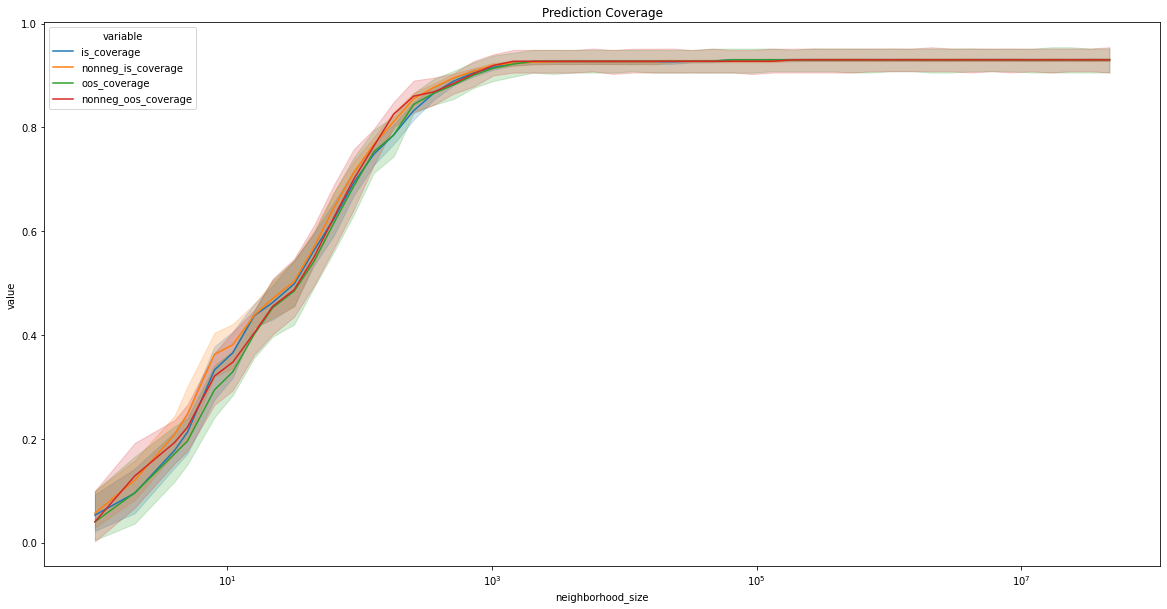

In [21]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

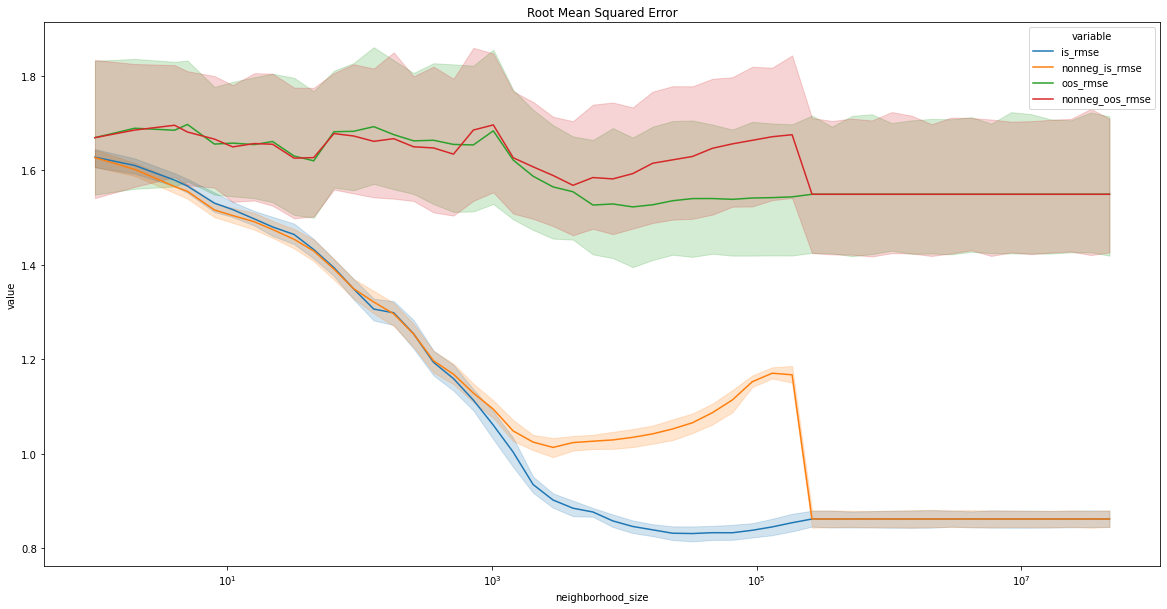

In [22]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [23]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(10)

is_coverage   is_rmse  oos_coverage  oos_rmse
nonneg_corrs neighborhood_size                                               
0.0          11585.0               0.926420  0.846337      0.927312  1.522630
             5792.0                0.926420  0.876991      0.927312  1.526580
             16384.0               0.926420  0.839230      0.927312  1.527132
             8192.0                0.926420  0.858104      0.927312  1.528848
             23170.0               0.926420  0.832048      0.927312  1.535632
             65536.0               0.929696  0.833050      0.930014  1.538637
             32768.0               0.927610  0.831408      0.927312  1.540248
             46340.0               0.927908  0.833197      0.927312  1.540326
             92681.0               0.929994  0.838301      0.930014  1.541393
             131072.0              0.929994  0.845411      0.930014  1.542263

In [24]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().xs(
    0, level="nonneg_corrs"
).sort_values(by="oos_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
11585.0,0.926420,0.846337,0.927312,1.522630
5792.0,0.926420,0.876991,0.927312,1.526580
16384.0,0.926420,0.839230,0.927312,1.527132
8192.0,0.926420,0.858104,0.927312,1.528848
23170.0,0.926420,0.832048,0.927312,1.535632
65536.0,0.929696,0.833050,0.930014,1.538637
32768.0,0.927610,0.831408,0.927312,1.540248
46340.0,0.927908,0.833197,0.927312,1.540326
92681.0,0.929994,0.838301,0.930014,1.541393


In [25]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().xs(
    0, level="nonneg_corrs"
).sort_values(by="is_rmse").head(10)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
32768.0,0.927610,0.831408,0.927312,1.540248
23170.0,0.926420,0.832048,0.927312,1.535632
65536.0,0.929696,0.833050,0.930014,1.538637
46340.0,0.927908,0.833197,0.927312,1.540326
92681.0,0.929994,0.838301,0.930014,1.541393
16384.0,0.926420,0.839230,0.927312,1.527132
131072.0,0.929994,0.845411,0.930014,1.542263
11585.0,0.926420,0.846337,0.927312,1.522630
185363.0,0.930291,0.854290,0.930014,1.543858


In [26]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
allerrors.groupby(["nonneg_corrs", "neighborhood_size"]).mean().xs(
    0, level="nonneg_corrs"
)

,is_coverage,is_rmse,oos_coverage,oos_rmse
neighborhood_size,,,,
1.0,0.053303,1.627751,0.040541,1.669173
2.0,0.095635,1.610375,0.096302,1.689098
4.0,0.178120,1.579301,0.171550,1.684878
5.0,0.212942,1.566686,0.195875,1.697146
8.0,0.332737,1.530612,0.294452,1.655569
11.0,0.365817,1.516898,0.329161,1.657593
16.0,0.437293,1.497254,0.401636,1.654565
22.0,0.462612,1.480233,0.452489,1.661046
32.0,0.498367,1.464265,0.484637,1.630258
